In [8]:
import numpy as np
from skfem import (
    MeshTri, Basis, FacetBasis, ElementTriP2, ElementTriP1, ElementVector,
    asm, bmat, condense, solve, BilinearForm, LinearForm, Mesh
)
from skfem.models.general import divergence
from skfem.models.poisson import vector_laplace
from skfem.helpers import grad, dot, laplacian
from skfem.helpers import laplacian, precompute_operators, precompute_operators_at_centroids
import matplotlib.pyplot as plt

import scipy.sparse as sp
from scipy.sparse.linalg import eigsh, eigs, splu, LinearOperator

import scipy.linalg

import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)


In [2]:
def graficar_stokes(u_sol, p_sol, mesh, basis_p, basis_u):
    
    Nu = basis_u.N
    
    # Visualización
    fig, axes = plt.subplots(2, 2, figsize=(18, 10))

    # Separar componentes de velocidad
    # Para ElementVector, los DOFs están organizados por componente
    n_nodes = Nu // 2
    u_x = u_sol[0::2]  # componente x
    u_y = u_sol[1::2]  # componente y

    # Magnitud de velocidad
    u_magnitude = np.sqrt(u_x**2 + u_y**2)

    # Crear bases escalares para visualizar cada componente
    basis_scalar = Basis(mesh, ElementTriP2(), intorder=4)

    # Componente u de la velocidad
    basis_scalar.plot(u_x, ax=axes[0, 0], shading='gouraud', colorbar=True)
    axes[0, 0].set_title(r'Velocidad $u_x$ (horizontal)')
    axes[0, 0].set_aspect('equal')

    # Componente v de la velocidad
    basis_scalar.plot(u_y, ax=axes[0, 1], shading='gouraud', colorbar=True)
    axes[0, 1].set_title(r'Velocidad $u_y$ (vertical)')
    axes[0, 1].set_aspect('equal')

    # Magnitud de velocidad
    basis_scalar.plot(u_magnitude, ax=axes[1, 0], shading='gouraud', colorbar=True)
    axes[1, 0].set_title(r'Magnitud de velocidad $|\mathbf{u}|$')
    axes[1, 0].set_aspect('equal')

    # Presión
    basis_p.plot(p_sol, ax=axes[1, 1], shading='gouraud', colorbar=True, colormap='viridis', cmap='viridis')
    axes[1, 1].set_title(r'Presión $p$')
    axes[1, 1].set_aspect('equal')
    plt.tight_layout()
    plt.show()

    # Campo vectorial de velocidad (quiver)
    # Para P2, necesitamos solo los valores en los vértices (primeros n_nodes)
    n_vertices = mesh.p.shape[1]
    
    # Extraer solo los valores en los vértices
    u_x_vertices = u_x[:n_vertices]
    u_y_vertices = u_y[:n_vertices]
    u_mag_vertices = np.sqrt(u_x_vertices**2 + u_y_vertices**2)
    
    # Obtener coordenadas de los nodos
    coords = mesh.p
    x_coords = coords[0, :]
    y_coords = coords[1, :]
    
    
    # Create a new figure for the quiver plot
    fig_quiver, ax_quiver = plt.subplots(1, 1, figsize=(10, 8))
    
    # Quiver plot
    quiver = ax_quiver.quiver(x_coords, y_coords, 
                      u_x_vertices, u_y_vertices, u_mag_vertices,
                      cmap='jet', scale=20, alpha=1, width=0.005)
    
    # Plot domain boundaries
    nodes  = mesh.p
    facets = mesh.facets
    boundary_facets = mesh.boundary_facets()

    # Plot all boundary facets
    for i, e in enumerate(boundary_facets):
        facets_e = facets[:, e]
        nodosx = nodes[0, facets_e]
        nodosy = nodes[1, facets_e]
        ax_quiver.plot(nodosx, nodosy, 'k-', linewidth=1.5, alpha=0.8)
    
    
    ax_quiver.set_title(r'Campo de velocidad $\mathbf{u}$')
    ax_quiver.set_aspect('equal')
    ax_quiver.set_xlabel('x')
    ax_quiver.set_ylabel('y')
    
    # Add colorbar
    cbar = plt.colorbar(quiver, ax=ax_quiver)
    cbar.set_label('Magnitud de velocidad')

    plt.tight_layout()
    plt.show()

In [5]:
# Definir dominio y mallado
nx, ny = 16, 16
mesh = MeshTri.init_tensor(
    np.linspace(0.0, 1.0, nx + 1), 
    np.linspace(0.0, 1.0, ny + 1)
)

In [6]:
# Asignar ID a las fronteras
mesh = mesh.with_boundaries({
    'left':   lambda x: x[0] == 0.0,
    'right':  lambda x: x[0] == 1.0,
    'bottom': lambda x: x[1] == 0.0,
    'top':    lambda x: x[1] == 1.0,
})

## Navier Stokes

In [7]:
# Definir elementos y bases (P2 para velocidad, P1 para presión)
element = {
    'u': ElementVector(ElementTriP2()),
    'p': ElementTriP1(),
}
basis = {
    'u': Basis(mesh, element['u'], intorder=4),
    'p': Basis(mesh, element['p'], intorder=4),
}
basis_u, basis_p = basis['u'], basis['p']
Nu, Np = basis_u.N, basis_p.N
N      = Nu + Np

In [14]:
@BilinearForm
def mass_matrix(u, v, w):
    return dot(u, v)

# Término convectivo linealizado
@BilinearForm
def convection(u, v, w):
    # w['w'] es la velocidad conocida (campo vectorial)
    advection_field = w['w']
    
    # grad(u) es el tensor gradiente de la velocidad trial
    grad_u = grad(u)
    
    # La operación es: w_j * (d u_i / d x_j) * v_i
    # j...  -> índice de w y de la derivada (contracción)
    # ij... -> índices del gradiente (componente i, derivada j)
    # i...  -> índice de v (componente i)
    return np.einsum('j...,ij...,i...->...', advection_field, grad_u, v)


# Ensamblaje de matrices
A =  asm(vector_laplace, basis_u)               
B = -asm(divergence, basis_u, basis_p)   

F_u = basis['u'].zeros()
F_p = basis['p'].zeros()
F = np.hstack([F_u, F_p])

In [15]:
def u_top_x(x, y):
    return 1 + 0*x*(1-x) + 0*y

In [16]:
x_boundary = np.zeros(Nu + Np)

# Fronteras de la velocidad

# Obtener DOFs de las fronteras de la base de velocidad
dofs_left     = basis_u.get_dofs('left').all()
dofs_right    = basis_u.get_dofs('right').all()
dofs_top      = basis_u.get_dofs('top').all()
dofs_bottom   = basis_u.get_dofs('bottom').all()

# Elementos con condiciones de Dirichlet para la velocidad
# Impares y, pares x
y_left   = basis_u.doflocs[1, dofs_left[1::2]] 
y_right  = basis_u.doflocs[1, dofs_right[1::2]]

x_left   = basis_u.doflocs[0, dofs_left[::2]]  
x_right  = basis_u.doflocs[0, dofs_right[::2]]

x_top    = basis_u.doflocs[0, dofs_top[::2]]
x_bottom = basis_u.doflocs[0, dofs_bottom[::2]]

y_top    = basis_u.doflocs[1, dofs_top[1::2]]
y_bottom = basis_u.doflocs[1, dofs_bottom[1::2]]


x_boundary[dofs_left[::2]]    =  0.0
x_boundary[dofs_left[1::2]]   =  0.0

x_boundary[dofs_right[::2]]   =  0.0
x_boundary[dofs_right[1::2]]  =  0.0

x_boundary[dofs_top[::2]]     =  u_top_x(x_top, y_top)  # componente x
x_boundary[dofs_top[1::2]]    =  0.0  # componente y

x_boundary[dofs_bottom[::2]]  =  0.0  # componente x
x_boundary[dofs_bottom[1::2]] =  0.0  # componente y

dofs_u_boundary = np.concatenate([
    dofs_left,
    dofs_right,
    dofs_top,
    dofs_bottom
])

x_boundary[Nu + 0]  = 0
dofs_p_boundary = np.array([Nu+0])# + np.concatenate([np.array([0])])

D_all = np.unique(np.concatenate([dofs_u_boundary, dofs_p_boundary]))

In [17]:
def solve_ns_picard(u_init, p_init, Re, max_iter, tol):
    u = u_init
    p = p_init
    for it in range(max_iter):
        # Campo de advección congelado w := u^(it) en puntos de cuadratura
        W = basis_u.interpolate(u)   

        # Ensambla bloque convectivo C(w)
        C = asm(convection, basis_u, w=W)

        # Matriz bloque del paso linealizado
        K = bmat([[(1/Re) * A + C, B.T ],
                  [B,              None]], format='csr')

        # Resolver
        sol = solve(*condense(K, F, D=D_all, x=x_boundary))
        u_new = sol[:Nu]
        p_new = sol[Nu:Nu+Np]

        # Criterio de convergencia
        du = u_new - u
        rel_u = np.linalg.norm(du) / (np.linalg.norm(u_new) + 1e-16)

        dp = p_new - p
        rel_p = np.linalg.norm(dp) / (np.linalg.norm(p_new) + 1e-16)

        # # Sub-relajación si se desea
        u = u_new
        p = p_new

        if rel_u < tol and rel_p < tol:
            print(f"Convergió en {it+1} iteraciones, residuo {max(rel_u, rel_p):.4e}")
            return u, p, True
    print("No convergió en el número máximo de iteraciones")
    return u, p, False

In [43]:
# Término convectivo linealizado
@BilinearForm
def convection(u, v, w):
    advection_field = w['w']
    grad_u = grad(u)
    return np.einsum('j...,ij...,i...->...', advection_field, grad_u, v)

@BilinearForm
def convection2(u, v, w):
    advection_field = u
    grad_w = grad(w['w'])
    return np.einsum('j...,ij...,i...->...', advection_field, grad_w, v)



In [73]:
def solve_ns_newton(u_init, p_init, Re, max_iter, tol):
    u = u_init
    p = p_init
    for it in range(max_iter):
        # Campo de advección congelado w := u^(it) en puntos de cuadratura
        W = basis_u.interpolate(u)   

        # Ensambla bloque convectivo C(w)
        C2 = asm(convection, basis_u, w=W)

        # Ensambla derivada del bloque convectivo C'(w)
        C1 = asm(convection2, basis_u, w=W)

        # Matriz bloque del paso linealizado
        DF = bmat([[(1/Re) * A + C1 + C2, B.T ],
                  [B,                        None]], format='csr')

        F1 = C2*u + (1/Re)*A*u + B.T*p 
        F2 = B*u
        F_real = np.concatenate([F1, F2])

        # Resolver
        delta = solve(*condense(DF, F_real, D=D_all, x=x_boundary*0))
        u_new = u - delta[:Nu]
        p_new = p - delta[Nu:Nu+Np]

        # Criterio de convergencia
        du = u_new - u
        rel_u = np.linalg.norm(du) / (np.linalg.norm(u_new) + 1e-16)

        dp = p_new - p
        rel_p = np.linalg.norm(dp) / (np.linalg.norm(p_new) + 1e-16)

        # # Sub-relajación si se desea
        u = u_new
        p = p_new

        # print(f"Iteración {it+1}: rel_u = {rel_u:.4e}, rel_p = {rel_p:.4e}")

        if rel_u < tol and rel_p < tol:
            print(f"Convergió en {it+1} iteraciones, residuo {max(rel_u, rel_p):.4e}")
            return u, p, True
    print("No convergió en el número máximo de iteraciones")
    return u, p, False

### Ciclo Picard aumentando Re

In [66]:
mu = 1.0

# Calcular solución inicial de stokes
K_stokes = bmat([[mu * A,     B.T],  
                 [B,         None]], format='csr')

sol0 = solve(*condense(K_stokes, F, D=D_all, x=x_boundary))
u_ref = sol0[:Nu].copy()
p_ref = sol0[Nu:Nu+Np].copy()

In [67]:
u_ref, p_ref, flag = solve_ns_newton(u_ref, p_ref, 1, max_iter=10, tol=1e-12)


Iteración 1: rel_u = 2.9801e-03, rel_p = 4.8555e-03
Iteración 2: rel_u = 2.5857e-08, rel_p = 8.3818e-08
Iteración 3: rel_u = 8.4360e-16, rel_p = 4.9765e-14
Convergió en 3 iteraciones, residuo 4.9765e-14


In [74]:
# Resolver incrementanto Re
Re = 100
Re_linspace = np.linspace(10, Re, 2)

for R in Re_linspace:
    print(f"Resolviendo para Re = {R:.2f}")
    u_ref, p_ref, flag = solve_ns_newton(u_ref, p_ref, R, max_iter=500, tol=1e-12)

    if not flag:
        print(f"No se pudo converger para este Re = {R:.2f}.")
        break

u_sol = u_ref
p_sol = p_ref


Resolviendo para Re = 10.00
Convergió en 4 iteraciones, residuo 2.3224e-13
Resolviendo para Re = 100.00
Convergió en 5 iteraciones, residuo 3.4778e-14


In [75]:
# Resolver incrementanto Re
Re = 100
Re_linspace = np.linspace(10, Re, 2)

for R in Re_linspace:
    print(f"Resolviendo para Re = {R:.2f}")
    u_ref, p_ref, flag = solve_ns_picard(u_ref, p_ref, R, max_iter=500, tol=1e-12)

    if not flag:
        print(f"No se pudo converger para este Re = {R:.2f}.")
        break

u_sol = u_ref
p_sol = p_ref


Resolviendo para Re = 10.00
Convergió en 11 iteraciones, residuo 7.6750e-14
Resolviendo para Re = 100.00
Convergió en 19 iteraciones, residuo 5.1343e-13


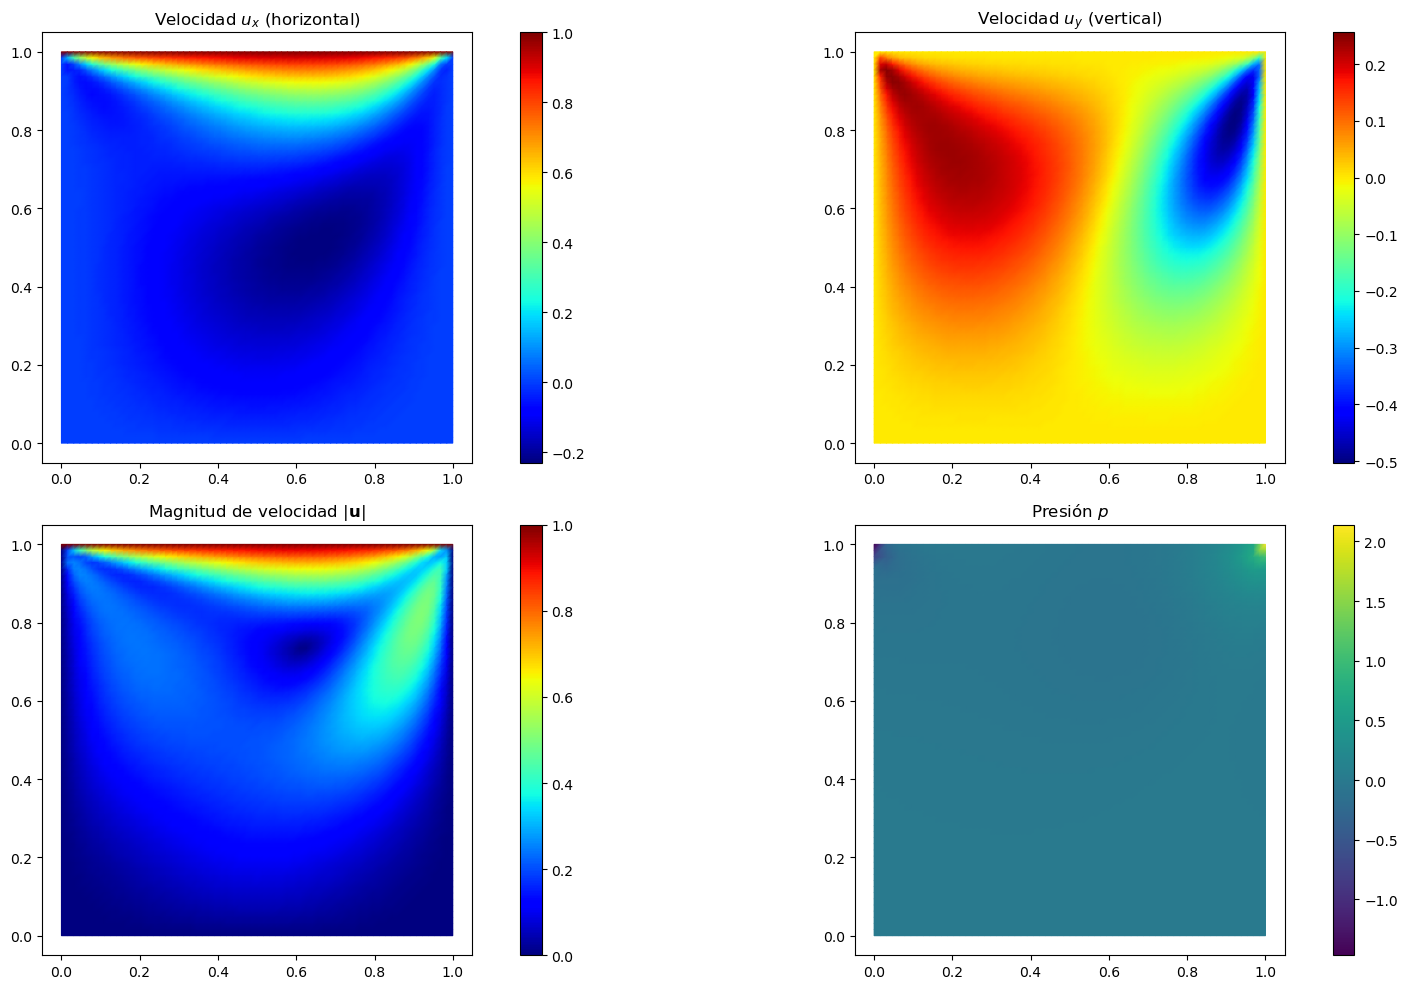

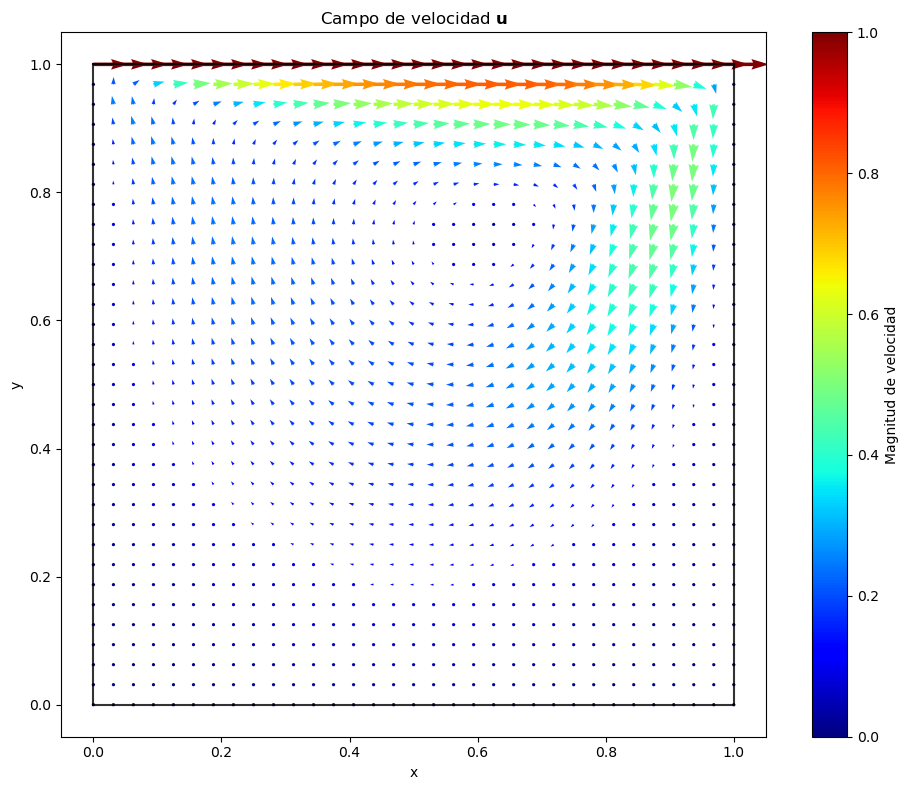

In [76]:
graficar_stokes(u_sol, p_sol, mesh, basis_p, basis_u)

### Residual

In [72]:
basis_x = basis_u.split_bases()[0]
basis_y = basis_u.split_bases()[1]
u_x = u_sol[0::2]
u_y = u_sol[1::2] 
p_sol = p_sol 

edofs_x, phix, grad_phix, laplacian_phix = precompute_operators(basis_x)
edofs_y, phiy, grad_phiy, laplacian_phiy = precompute_operators(basis_y)
edofs_p, phip, grad_phip, laplacian_phip = precompute_operators(basis_p)
# Velocidad y presión en puntos de cuadratura
u_val = np.einsum('dq, de -> qe', phix, u_x[edofs_x]) 
v_val = np.einsum('dq, de -> qe', phiy, u_y[edofs_y])
p_val = np.einsum('dq, de -> qe', phip, p_sol[edofs_p])

# Calcular operadores en coordenadas físicas
grad_u_fisico_x = np.einsum('de, diqe -> iqe', u_x[edofs_x], grad_phix)
grad_u_fisico_y = np.einsum('de, diqe -> iqe', u_y[edofs_y], grad_phiy)
grad_p_fisico   = np.einsum('de, diqe -> iqe', p_sol[edofs_p], grad_phip)
laplacian_u_x   = np.einsum('de, de -> e', u_x[edofs_x], laplacian_phix)
laplacian_u_y   = np.einsum('de, de -> e', u_y[edofs_y], laplacian_phiy)

du_dx = grad_u_fisico_x[0]
du_dy = grad_u_fisico_x[1]
dv_dx = grad_u_fisico_y[0]
dv_dy = grad_u_fisico_y[1]
dp_dx = grad_p_fisico[0]
dp_dy = grad_p_fisico[1]


# Residuo momentum en X: dp/dx - nu*Lap(u)
res_momentum_x = np.abs((u_val * du_dx + v_val * du_dy) + dp_dx - (laplacian_u_x/Re))

# Residuo momentum en Y: dp/dy - nu*Lap(v)
res_momentum_y = np.abs((u_val * dv_dx + v_val * dv_dy) + dp_dy - (laplacian_u_y/Re))

# Residuo Continuidad: du/dx + dv/dy
res_continuity = np.abs(du_dx + dv_dy)

print(f"Residuo momentum en X - min: {np.min(res_momentum_x):.4e}, max: {np.max(res_momentum_x):.4e}")
print(f"Residuo momentum en Y - min: {np.min(res_momentum_y):.4e}, max: {np.max(res_momentum_y):.4e}")
print(f"Residuo continuidad - min: {np.min(res_continuity):.4e}, max: {np.max(res_continuity):.4e}")

Residuo momentum en X - min: 2.5096e-08, max: 4.8179e+01
Residuo momentum en Y - min: 4.0954e-07, max: 2.8148e+01
Residuo continuidad - min: 8.6736e-19, max: 1.7385e+01


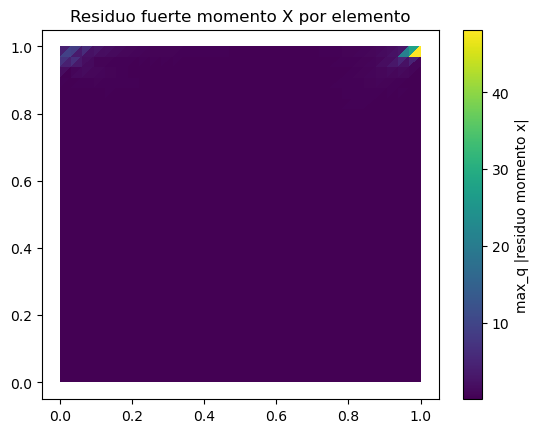

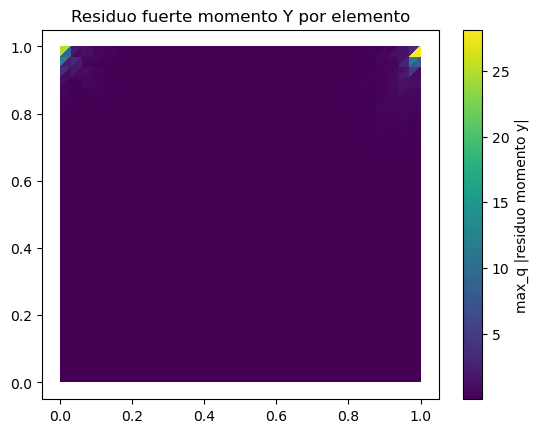

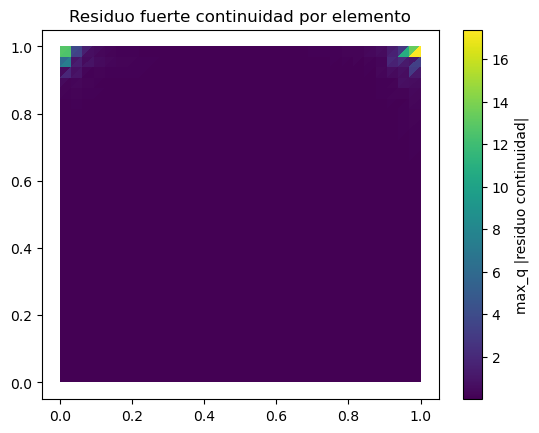

In [14]:
# Maximo por elemento
resx_elem = res_momentum_x.max(axis=0)   # (n_elem,)
resy_elem = res_momentum_y.max(axis=0)
resc_elem = res_continuity.max(axis=0)

# Geometria de la malla
p = basis_x.mesh.p.T   # nodos: shape (n_nodes, 2)
t = basis_x.mesh.t.T   # elementos (triangulos): shape (n_elem, nvert)


plt.figure()
plt.tripcolor(p[:, 0], p[:, 1], t, facecolors=resx_elem, shading="flat")
plt.colorbar(label="max_q |residuo momento x|")
plt.title("Residuo fuerte momento X por elemento")

plt.figure()
plt.tripcolor(p[:, 0], p[:, 1], t, facecolors=resy_elem, shading="flat")
plt.colorbar(label="max_q |residuo momento y|")
plt.title("Residuo fuerte momento Y por elemento")

plt.figure()
plt.tripcolor(p[:, 0], p[:, 1], t, facecolors=resc_elem, shading="flat")
plt.colorbar(label="max_q |residuo continuidad|")
plt.title("Residuo fuerte continuidad por elemento")

plt.show()


### Week loss

In [15]:
# Internal DOFs
dofs_boundary_u = jnp.asarray(basis_u.boundary().get_dofs().all())
dofs_all_u      = jnp.arange(basis_u.dofs.N, dtype=jnp.int64)
dofs_internal_u = jnp.setdiff1d(dofs_all_u, dofs_boundary_u)

dofs_boundary_p = jnp.asarray(basis_p.boundary().get_dofs().all())
dofs_all_p      = jnp.arange(basis_p.dofs.N, dtype=jnp.int64)
dofs_internal_p = jnp.setdiff1d(dofs_all_p, dofs_boundary_p)

basis_x = basis_u.split_bases()[0]
basis_y = basis_u.split_bases()[1]
u_x = u_sol[0::2]
u_y = u_sol[1::2]

edofs_x, phix, grad_phix, _ = precompute_operators(basis_x, calculate_laplacian=False)
edofs_y, phiy, grad_phiy, _ = precompute_operators(basis_y, calculate_laplacian=False)
edofs_p, phip, _, _ = precompute_operators(basis_p, calculate_laplacian=False)
#(q,e) , (d,q), (d,i,q,e)

dx = basis_x.dx #(d,e)

# Transformar a Jax arrays
dtype_float = jnp.float64
dtype_int   = jnp.int64
u_sol = jnp.asarray(u_sol, dtype=dtype_float)
p_sol = jnp.asarray(p_sol, dtype=dtype_float)
dx    = jnp.asarray(dx, dtype=dtype_float)
edofs_x = jnp.asarray(edofs_x, dtype=dtype_int)
edofs_y = jnp.asarray(edofs_y, dtype=dtype_int)
edofs_p = jnp.asarray(edofs_p, dtype=dtype_int)
phix = jnp.asarray(phix, dtype=dtype_float)
phiy = jnp.asarray(phiy, dtype=dtype_float)
phip = jnp.asarray(phip, dtype=dtype_float)
grad_phix = jnp.asarray(grad_phix, dtype=dtype_float)
grad_phiy = jnp.asarray(grad_phiy, dtype=dtype_float)
basis_u_elements_dofs = jnp.asarray(basis_u.element_dofs, dtype=dtype_int)

#### Error ecuaciones de momentum

In [16]:
def compute_residual_for_dof_padded(elem_idx, loc_scalar, comp, mask,
                                    Re,
                                    u_sol, p_sol,
                                    edofs_x, edofs_y, edofs_p,
                                    phix, phiy, phip,
                                    grad_phix, grad_phiy,
                                    dx):
    """
    elem_idx  : (Ne_max,)
    loc_scalar: (Ne_max,)
    comp      : escalar (0 o 1)
    mask      : (Ne_max,) con 1 para elementos reales, 0 padding
    """

    Ne_max = elem_idx.shape[0]

    # 2) Pesos y edofs para el DOF (Ne_max)
    weights_dx = dx[elem_idx, :].T                    # (q, Ne_max)
    weights_dx = weights_dx * mask[None, :]           # enmascara padding

    edofs_x_target = edofs_x[:, elem_idx]             # (d, Ne_max)
    edofs_y_target = edofs_y[:, elem_idx]             # (d, Ne_max)
    edofs_p_target = edofs_p[:, elem_idx]             # (d, Ne_max)

    u_x = u_sol[0::2]
    u_y = u_sol[1::2]

    u_x_target   = u_x[edofs_x_target]                # (d, Ne_max)
    u_y_target   = u_y[edofs_y_target]                # (d, Ne_max)
    p_sol_target = p_sol[edofs_p_target]              # (d, Ne_max)

    # 3) gradientes base sobre la estrella
    grad_phi_x_target = grad_phix[:, :, :, elem_idx]  # (d, i, q, Ne_max)
    grad_phi_y_target = grad_phiy[:, :, :, elem_idx]  # (d, i, q, Ne_max)

    # 4) Reconstruccion u_h, p_h, grad u_h
    u_x_h = jnp.einsum('de,dq->qe', u_x_target, phix)   # (q, Ne_max)
    u_y_h = jnp.einsum('de,dq->qe', u_y_target, phiy)   # (q, Ne_max)
    p_h   = jnp.einsum('de,dq->qe', p_sol_target, phip) # (q, Ne_max)

    grad_u_x_h = jnp.einsum('de,diqe->iqe', u_x_target, grad_phi_x_target) # (i, q, Ne_max)
    grad_u_y_h = jnp.einsum('de,diqe->iqe', u_y_target, grad_phi_y_target) # (i, q, Ne_max)

    # 5) Construir v y grad v para todos los elementos (sin if de Python)

    # grad_phi_x_e: (Ne_max, d, i, q)
    grad_phi_x_e = jnp.transpose(grad_phi_x_target, (3, 0, 1, 2))
    grad_phi_y_e = jnp.transpose(grad_phi_y_target, (3, 0, 1, 2))
    idx_e = jnp.arange(Ne_max)

    # v para ux
    v_x_candidate = phix[loc_scalar, :].T                       # (q, Ne_max)
    v_y_candidate = phiy[loc_scalar, :].T                       # (q, Ne_max)

    grad_vx_e_candidate = grad_phi_x_e[idx_e, loc_scalar, :, :] # (Ne_max, i_dim, q)
    grad_vy_e_candidate = grad_phi_y_e[idx_e, loc_scalar, :, :] # (Ne_max, i_dim, q)

    grad_vx_cand = jnp.transpose(grad_vx_e_candidate, (1, 2, 0)) # (i_dim, q, Ne_max)
    grad_vy_cand = jnp.transpose(grad_vy_e_candidate, (1, 2, 0)) # (i_dim, q, Ne_max)

    # comp==0 -> DOF de ux, comp==1 -> DOF de uy
    comp_is_x = (comp == 0)

    v_target_x = jnp.where(comp_is_x, v_x_candidate, jnp.zeros_like(v_x_candidate))
    v_target_y = jnp.where(comp_is_x, jnp.zeros_like(v_y_candidate), v_y_candidate)

    grad_vx_target = jnp.where(comp_is_x,
                               grad_vx_cand,
                               jnp.zeros_like(grad_vx_cand))
    grad_vy_target = jnp.where(comp_is_x,
                               jnp.zeros_like(grad_vy_cand),
                               grad_vy_cand)

    # 6) Residuo
    diff_term_x = jnp.einsum('iqe,iqe->qe', grad_u_x_h, grad_vx_target)
    diff_term_y = jnp.einsum('iqe,iqe->qe', grad_u_y_h, grad_vy_target)

    conv_term_x = ((u_x_h * grad_u_x_h[0, :, :]) +
                   (u_y_h * grad_u_x_h[1, :, :])) * v_target_x
    conv_term_y = ((u_x_h * grad_u_y_h[0, :, :]) +
                   (u_y_h * grad_u_y_h[1, :, :])) * v_target_y

    press_term_x = p_h * grad_vx_target[0, :, :]
    press_term_y = p_h * grad_vy_target[1, :, :]

    integrando_x = (1.0 / Re) * diff_term_x + conv_term_x - press_term_x
    integrando_y = (1.0 / Re) * diff_term_y + conv_term_y - press_term_y

    # enmascarar padding otra vez por seguridad
    integrando_x = integrando_x * mask[None, :]
    integrando_y = integrando_y * mask[None, :]

    residuo_x = jnp.sum(integrando_x * weights_dx)
    residuo_y = jnp.sum(integrando_y * weights_dx)

    return residuo_x, residuo_y


In [17]:
compute_residuals_vmap = jax.vmap(
    compute_residual_for_dof_padded,
    in_axes=(
        0,  # elem_idx   -> (n_dof_eval, Ne_max)
        0,  # loc_scalar -> (n_dof_eval, Ne_max)
        0,  # comp       -> (n_dof_eval,)
        0,  # mask       -> (n_dof_eval, Ne_max)
        None,  # Re
        None,  # u_sol
        None,  # p_sol
        None,  # edofs_x
        None,  # edofs_y
        None,  # edofs_p
        None,  # phix
        None,  # phiy
        None,  # phip
        None,  # grad_phix
        None,  # grad_phiy
        None   # dx
    )
)

compute_residual_jit = jax.jit(compute_residuals_vmap)

In [18]:
def precompute_dof_connectivity_V2(basis_u_element_dofs, dofs_eval):
    """
    basis_u_element_dofs: array (n_ldofs_vec, n_elem)

    dofs_eval: array 1D with the global DOFs to evaluate, shape (n_dof_eval,)

    Return:
        elem_idx_per_dof   : (n_dof_eval, Ne_max)   element indexes per DOF
        loc_scalar_per_dof : (n_dof_eval, Ne_max)   local scalar index (0..d-1)
        mask_per_dof       : (n_dof_eval, Ne_max)   1.0 if the entry is real, 0.0 if padding
        comp_per_dof       : (n_dof_eval,)          component (0: ux, 1: uy)
    """

    basis_u_element_dofs = np.asarray(basis_u_element_dofs, dtype=int)
    dofs_eval            = np.asarray(dofs_eval, dtype=int)

    n_ldofs_vec, n_elem = basis_u_element_dofs.shape  # (local_vec, elem)
    n_dof_eval          = dofs_eval.shape[0]

    # 1) Map  Global DOF -> row in output arrays
    max_dof    = int(basis_u_element_dofs.max())
    dof_to_row = -np.ones(max_dof + 1, dtype=int)
    for r, dof in enumerate(dofs_eval):
        if dof <= max_dof:
            dof_to_row[dof] = r

    # 2) For each DOF in dofs_eval, we will store a list of (elem, local_vec)
    elem_lists = [[] for _ in range(n_dof_eval)]

    # basis_u_element_dofs[local_vec, elem] = dof_global
    for local_vec in range(n_ldofs_vec):
        for elem in range(n_elem):
            dof = int(basis_u_element_dofs[local_vec, elem])
            r   = dof_to_row[dof]
            if r < 0:
                continue
            elem_lists[r].append((elem, local_vec))

    # 3) Compute Ne_max: maximum size of the DOF among the evaluated DOFs
    Ne_list = [len(lst) for lst in elem_lists]
    Ne_max  = max(Ne_list)

    # 4) Initialize output arrays (NumPy)
    elem_idx_per_dof   = np.full((n_dof_eval, Ne_max), fill_value=-1, dtype=int)
    loc_scalar_per_dof = np.zeros((n_dof_eval, Ne_max), dtype=int)
    mask_per_dof       = np.zeros((n_dof_eval, Ne_max), dtype=float)
    comp_per_dof       = np.zeros((n_dof_eval,), dtype=int)

    # 5) Fill  row by row:
    #    local_vec = pos_local_u
    #    comp_local = local_vec % 2
    #    loc_scalar = local_vec // 2
    for r in range(n_dof_eval):
        pares = elem_lists[r]
        if not pares:
            continue

        Ne = len(pares)
        elem_idx   = np.empty((Ne,), dtype=int)
        loc_scalar = np.empty((Ne,), dtype=int)
        comp_local = np.empty((Ne,), dtype=int)

        for k, (elem, local_vec) in enumerate(pares):
            elem_idx[k]   = elem
            comp_local[k] = local_vec % 2      # 0: component x, 1: component y
            loc_scalar[k] = local_vec // 2     # local scalar DOF
        elem_idx_per_dof[r, :Ne]   = elem_idx
        loc_scalar_per_dof[r, :Ne] = loc_scalar
        mask_per_dof[r, :Ne]       = 1.0
        comp_per_dof[r]            = comp_local[0]  # same component in the entire support

    # 6) Convert to JAX
    elem_idx_per_dof_j   = jnp.asarray(elem_idx_per_dof, dtype=jnp.int64)
    loc_scalar_per_dof_j = jnp.asarray(loc_scalar_per_dof, dtype=jnp.int64)
    mask_per_dof_j       = jnp.asarray(mask_per_dof, dtype=jnp.float64)
    comp_per_dof_j       = jnp.asarray(comp_per_dof, dtype=jnp.int64)

    return elem_idx_per_dof_j, loc_scalar_per_dof_j, mask_per_dof_j, comp_per_dof_j


In [19]:
# Precomputar conectividad de DOFs internos de velocidad
elem_idx, loc_scalar, mask, comp = \
    precompute_dof_connectivity_V2(jnp.array(basis_u.element_dofs), dofs_internal_u)

In [20]:
res_x, res_y = compute_residual_jit(
    elem_idx,
    loc_scalar,
    comp,
    mask,
    Re,
    u_sol, p_sol,
    edofs_x, edofs_y, edofs_p,
    phix, phiy, phip,
    grad_phix, grad_phiy,
    dx
)
# res_x, res_y: shape (n_dof_eval,)
print("Residuos computados con JAX vmap:")
print(f'Componente x: Máximo error: {jnp.max(jnp.abs(res_x)):4e}, Minimo error: {jnp.min(jnp.abs(res_x)):4e}')
print(f'Componente y: Máximo error: {jnp.max(jnp.abs(res_y)):4e}, Minimo error: {jnp.min(jnp.abs(res_y)):4e}') # Por revisar

Residuos computados con JAX vmap:
Componente x: Máximo error: 1.396994e-16, Minimo error: 0.000000e+00
Componente y: Máximo error: 1.639856e-16, Minimo error: 0.000000e+00
